<a href="https://colab.research.google.com/github/Tookss55/DS/blob/main/Unit4/Unit4ExerciesSF_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
!pip install preliz
import preliz as pz

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

with pm.Model(coords=aa_coords) as cs_h_model: # StudentT Distribution
    μ_mu_hp = pm.StudentT('μ_mu_hp', mu = 0, sigma = 10, nu = 30)
    μ_sigma_hp = pm.HalfStudentT('μ_sigma_hp', sigma = 10, nu = 30)
    μ_nu_hp = pm.HalfStudentT('μ_nu_hp', sigma = 10, nu = 30)

    μ = pm.StudentT('μ',mu = μ_mu_hp, sigma = μ_sigma_hp, nu = μ_nu_hp, dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 30, dims = "aa")

    ν = pm.HalfStudentT('ν', sigma = 10, nu = 30, dims = "aa")

    y = pm.StudentT('y', mu = μ[aa_idx], sigma = σ[aa_idx], nu = ν[aa_idx], observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model_2: # Normal Distribution
    μ_mu_hp = pm.Normal('μ_mu_hp', mu = 0, sigma = 10)
    μ_sigma_hp = pm.HalfNormal('μ_sigma_hp', sigma = 10)

    μ = pm.Normal('μ', mu = μ_mu_hp, sigma = μ_sigma_hp, dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10, dims = "aa")

    y = pm.Normal('y', mu = μ[aa_idx], sigma = σ[aa_idx], observed = cs_data.diff_TminusE)

    idata_cs_h_2 = pm.sample()

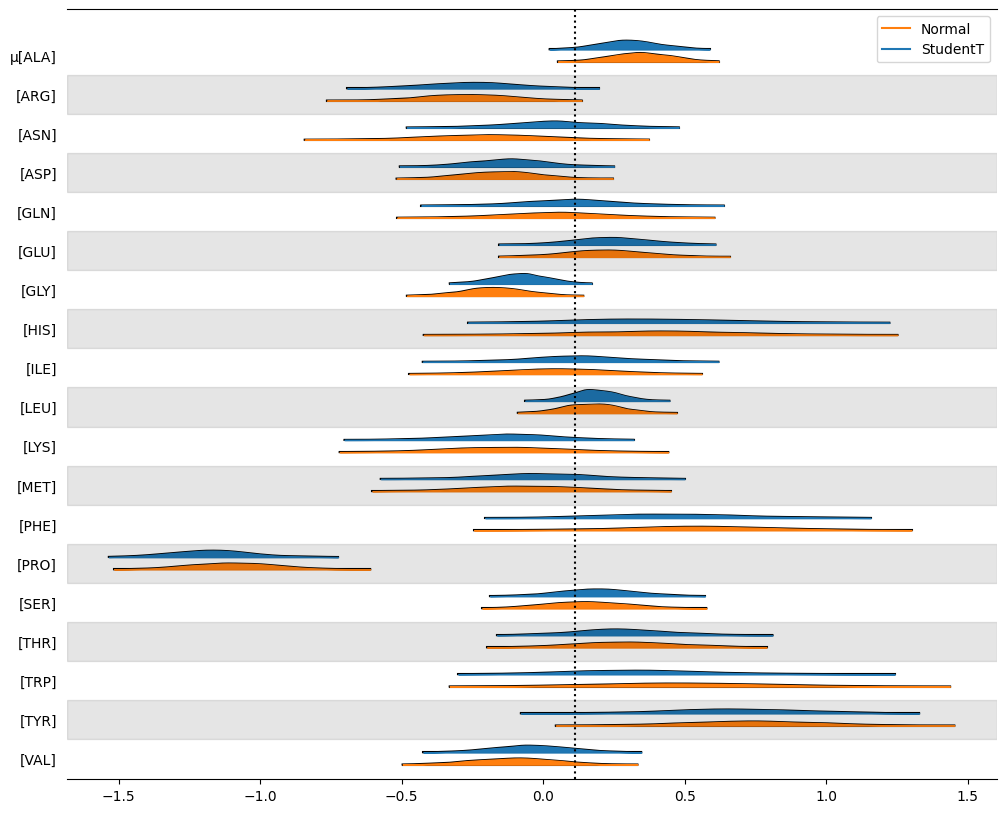

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_h_2], kind="ridgeplot",
                      model_names=['StudentT', 'Normal'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots the  mean of the hierarchical model, also I got help from yale on this task
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu_hp'].mean(), *y_lims, color="k", ls=":");

The student T distribution is a more accurate model for majority of the amino acids because it's closer to the mean.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
#This will check the posterior predictive for the StudentT prior and likelihood
pm.sample_posterior_predictive(idata_cs_h,

                               model = cs_h_model,

                               extend_inferencedata=True)


(-10.0, 10.0)

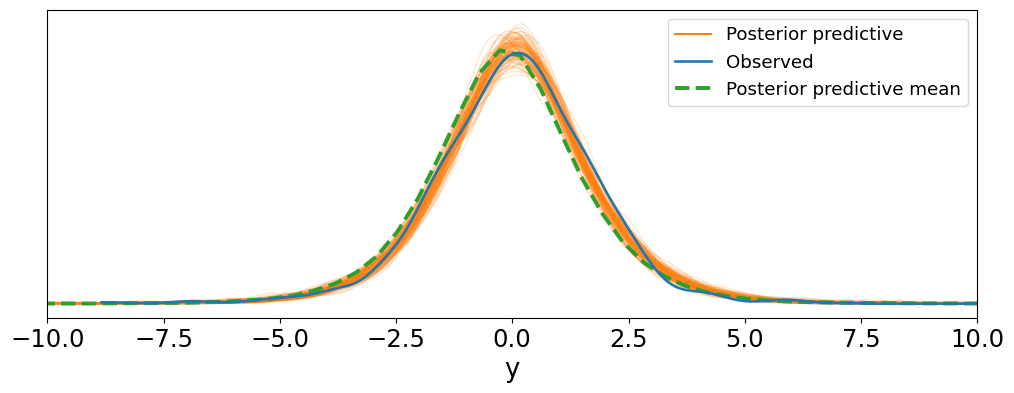

In [ ]:
ax = az.plot_ppc(idata_cs_h,
                 num_pp_samples=100,
                 figsize=(12, 4),
                 colors = ["C1", "C0", "C2"])

ax.set_xlim(-10,10)

In [ ]:
#This will check the posterior predictive for the Normal distribution prior and likelihood
pm.sample_posterior_predictive(idata_cs_h_2,
                               model = cs_h_model_2,
                               extend_inferencedata = True)

(-10.0, 10.0)

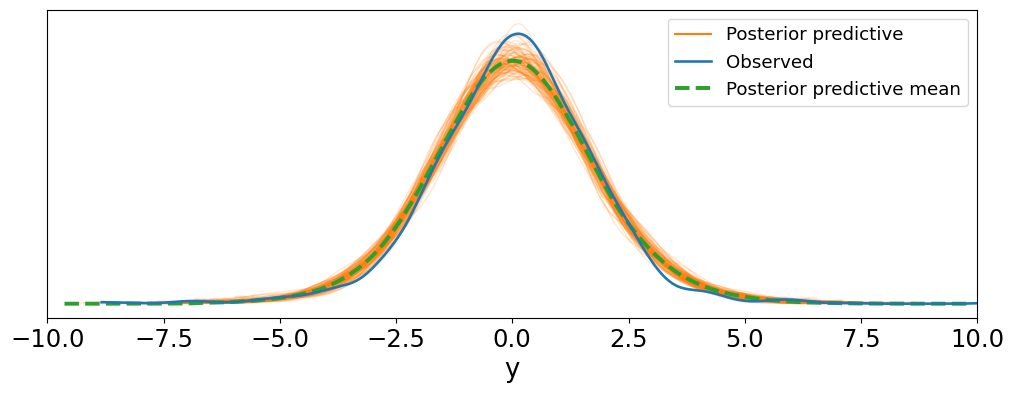

In [ ]:
ax = az.plot_ppc(idata_cs_h_2,
                 num_pp_samples = 100,
                 figsize = (12, 4),
                 colors = ["C1", "C0", "C2"])

ax.set_xlim(-10,10)

Based on the two graphs, the StudentT model is a much better fit, specifically when looking at the peak of the distribution. The normal posterior predictive is signicantly below the observed data, compared to the StudentT posterior predictive which is practically spot on.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [4]:
soccer_url = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
soccer_data = pd.read_csv(soccer_url, dtype = {'position':'category'})
soccer_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [15]:
pos_idx = soccer_data.position.cat.codes.values

pos_coords = {"position": soccer_data.position.cat.categories} #this will put the coords in a dict, so pymc can read them

In [ ]:
with pm.Model(coords = pos_coords) as soccer_model:

  #position parameters
  μ = pm.Beta('μ', mu = 0.1, nu = 55, dims = "position")
  ν = pm.Gamma('ν', mu = 55, sigma = 45, dims = "position")
  #player parameters
  θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

  #n represents the shots for each player, p is my guess for goals per shot, and observed is the goals each player scores
  soccer = pm.Binomial('soccer',
                       n = soccer_data.shots.values,
                       p = θ,
                       observed = soccer_data.goals.values)

  idata_soccer = pm.sample(target_accept = 0.95)
  #I initially had the target_accept set to 1, and was getting errors, so I asked Gemini and it told me to decrease it slightly
  #Gemini also told me to make slight changes to my inidial mu, sigma, and nu in lines 2 and 3 to prevent divergences.

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:   (θ_dim_0: 2682, position: 4)
Coordinates:
  * θ_dim_0   (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * position  (position) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ         (θ_dim_0) float64 21kB 1.007 0.9997 1.0 ... 1.003 0.9997 1.001
    μ         (position) float64 32B 1.003 1.002 1.021 1.001
    ν         (position) float64 32B 1.012 1.001 1.038 1.008

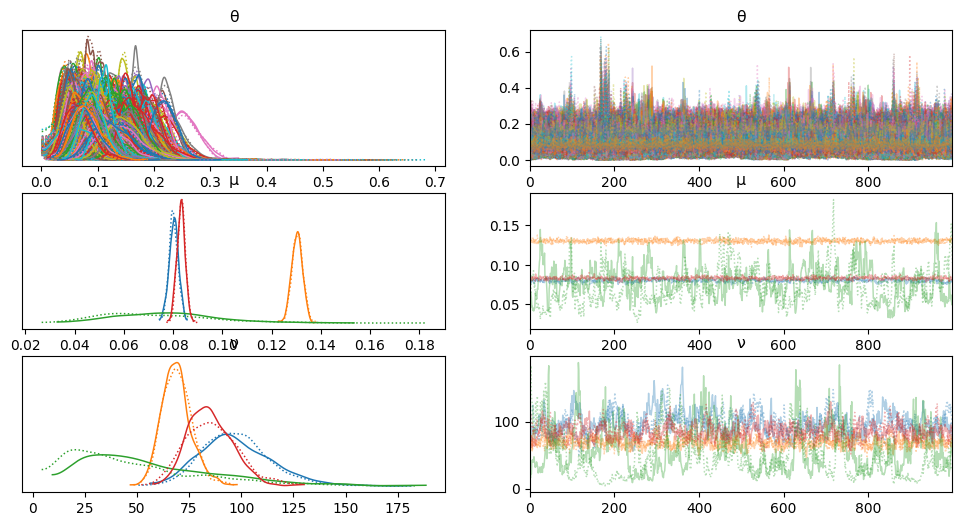

In [17]:
az.plot_trace(idata_soccer)
az.rhat(idata_soccer)

The R hat values for the nonhierarchical model are usually farther from 1 than the hierarchical ones (for μ, ν, and θ, which both models share). This is most noticeable with the ν R hat values. The nonhierarchical model went up to 1.232, while the hierarchical model stayed closer to 1.172. The θ and μ_p R hat values, though, were pretty close between the two models. Both had θ values within 0.005 of 1 and μ values within 0.05 of 1. I also thought it was interesting that the θ R hat values were the only ones that went slightly below 1.

Looking at the trace plots, θ looks almost the same for both models, since both stay under 0.75. The nonhierarchical one seems to have a few more spikes or outliers. For μ and ν, the nonhierarchical model seems to go higher and have more outliers. For example, ν in the hierarchical model only goes a bit above 200, while in the nonhierarchical model it goes above 300 in some spots. Still, the overall shapes of the μ and ν traces are pretty similar.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

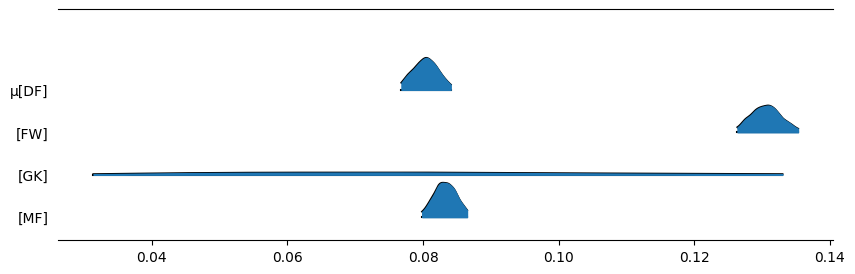

In [ ]:
az.plot_forest(idata_soccer, var_names=['μ'], combined=True, figsize=(10, 3), kind = 'ridgeplot', hdi_prob=0.95)

The hierarchical and nonhierarchical models are pretty much the same. In general, the peaks and widths of the curves are practically identical. The goal-keeper models are very all over the place though.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [7]:
soccer_data_2 = pd.read_csv(soccer_url)
soccer_data_2 = soccer_data_2.query('position != "GK"')
soccer_data_2['position'] = soccer_data_2['position'].astype('category')
soccer_data_2

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [9]:
pos_idx_2 = soccer_data_2.position.cat.codes.values

pos_codes_2 = soccer_data_2.position.cat.categories

soccer_coords_2 = {"position": pos_codes_2}


In [ ]:
with pm.Model(coords = soccer_coords_2) as sccr_model_h: # hierarchical without goalkeepers
    μ = pm.Beta('μ',
                alpha = 2,
                beta = 20)

    ν = pm.Gamma('ν',
                 mu = 55,
                 sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "position")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="position")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_2], nu = ν_p[pos_idx_2])

    #how many shots and goals each player has:
    _ = pm.Binomial('gs',
                    n = soccer_data_2.shots.values,
                    p = θ,
                    observed = soccer_data_2.goals.values)

    #got help from Gemini to hone in my mu and sigma for the ν_p parameter
    idata_soccer_2 = pm.sample(target_accept = 0.95)


<xarray.Dataset> Size: 40kB
Dimensions:   (θ_dim_0: 2517, position: 3)
Coordinates:
  * θ_dim_0   (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * position  (position) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ         (θ_dim_0) float64 20kB 1.002 1.003 1.002 1.001 ... 1.002 1.002 1.0
    μ         float64 8B 1.003
    μ_p       (position) float64 24B 1.004 0.9999 1.001
    ν         float64 8B 1.001
    ν_p       (position) float64 24B 1.03 1.001 1.009

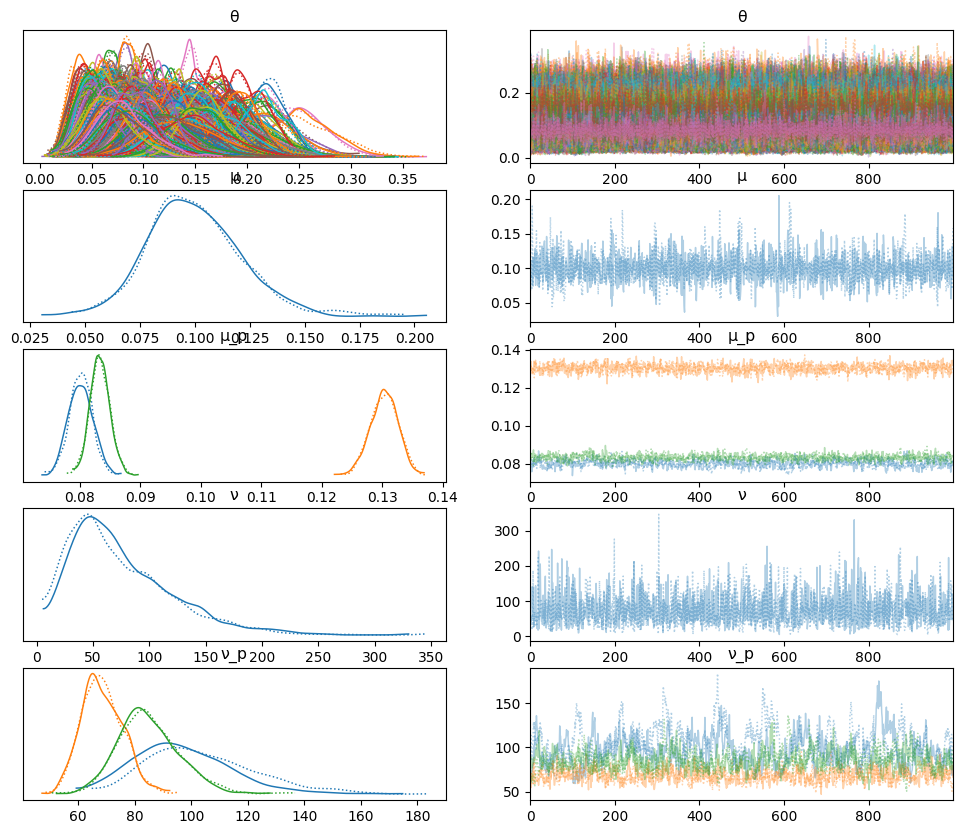

In [13]:
az.plot_trace(idata_soccer_2)
az.rhat(idata_soccer_2)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The hierarchical model without goalkeeper stats ran a lot faster in pymc. The one with goalkeeper stats took about 8 minutes to finish, while the one without them only took about 4 minutes.

When we remove the goalkeeper stats, we lose a bit of data, but the graphs look much cleaner. The model without goalkeeper stats had R hat values that were almost all within 0.01 of 1, and the trace plots looked more stable, especially for θ and ν_p.